# Plotting tools

In this notebook we showcase some of the plotting functionalities available.

In [1]:
%load_ext autoreload
%autoreload 2

# set-up
import sys, os 
from dotenv import load_dotenv
load_dotenv("../.env")
sys.path.append(os.environ.get("SRC_FOLDER"))

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.subplots

# Parameters 
random_factor = 9374
figs_path = "."

In [3]:
import causalinf.ab.synthetic_control
import causalinf.plot

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Data Exploration

In [4]:
df = pd.read_csv(os.path.join(os.environ.get("SRC_FOLDER"), "tests/fixtures/ga-visits-usa-cities.csv"))
df = causalinf.libs.pd_tools.format_dataframe( df, columns_datetime = ["period_start_date"])
df.head(3)

# Define treated and control units
treated_unit = "Houston"
control_units = [cc for cc in df.columns if cc not in [treated_unit, "period_start_date", "test_active"]]
step_intervention =  df[df["test_active"]==1].index.min()

# split data: pre/post test
# df = df.set_index("period_start_date")
mask_pre = df["test_active"]==0
df_pre, df_post = df.loc[mask_pre,[treated_unit]+control_units], df.loc[~mask_pre,[treated_unit]+control_units]


### Matplotlib backend

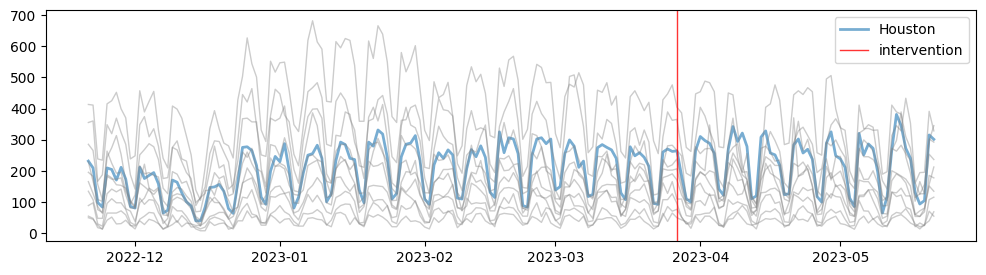

In [5]:
fig = plt.figure(figsize=(12.,3.))
Ax = fig.subplots(1,1,squeeze=False)
ax = Ax[0,0]
causalinf.plot.main.plot_units(
    df, treated_unit, control_units, step_intervention, col_time="period_start_date", 
    plot_args={"ax": ax}, backend="matplotlib" )
ax.legend()
plt.show()

# You can save figures from this notebook, or programmatically, as below:
fig.savefig( os.path.join( figs_path, "demo-backend-matplotlib.png"), transparent=True)
fig.savefig( os.path.join( figs_path, "demo-backend-matplotlib.pdf"), transparent=True)

### Plotly backend

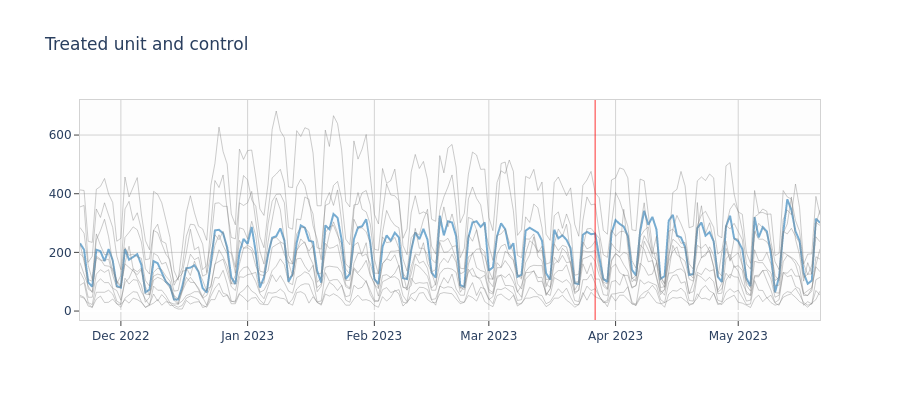

In [6]:
import plotly.graph_objects as go
fig = plotly.subplots.make_subplots(rows=1, cols=1)
causalinf.plot.main.plot_units(
    df, treated_unit, control_units, step_intervention, col_time="period_start_date", 
    plot_args={"fig": fig}, backend="plotly" )
fig.update_layout(
    height=400, width=900, title_text="Treated unit and control", showlegend=False)

# For interactive figures - commented out as they won't render in github
# fig.show()
# For static render (as "png", "svg"; see plotly.io.renderers for all available options)
fig.show("png")

# You can save figures from this notebook, or programmatically, as below:
fig.write_image( os.path.join( figs_path, "demo-backend-plotly.png"))
fig.write_image( os.path.join( figs_path, "demo-backend-plotly.pdf"))

# You can also export figures as html, e.g. for sharing with/presentig to clients
fig.write_html( os.path.join( figs_path, "demo-backend-plotly.html"))

# Fit Synthetic Control Model

Here are some recommendations on how to set the model parameters:

-  `coef_bounds`: Ideally, avoid negative coefficients or much larger than 1.
- `fit_intercept`: Ideally, try without fitting an intercept - use only if needed. When using, try to avoid large values of the intercept (as these may be unphysical and hard to justify to the client), unless you have a valid reason for doing so.
- `l1_ratio`. This is a regularisation term as per [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html). Higher values will help removing from the control covariates less impactful covariates. Optionally, you can use the `sc.fit_hyperparameters` method to optimise the `l1_ratio`.

In [7]:
dX_pre, dy_pre = df_pre[control_units], df_pre[[treated_unit]]
dX_post, dy_post = df_post[control_units], df_post[[treated_unit]]

In [8]:
model_params = dict(
    coef_bounds=(0.0, 1.2),
    fit_intercept = True
)
sc = causalinf.ab.synthetic_control.linear.models.GeneralRegressor(**model_params)
# sc.fit_hyperparameters(dX_pre.values, dy_pre.values)
sc._fit_intercept(dX_pre, dy_pre)
sc.fit(dX_pre, dy_pre)
print(f"Fit stats:\n"+sc._fit_stats.__str__())

Fit stats:
error_mean: 0.001
error_std: 27.107
r2: 0.88
mse: 734.808
rmse: 27.107



# Inference

The inference process, happens at different level. 
1. We compute the cumulative causal impact over the whole campaign period. Here, we want to verify that the uncertainty around this value is *low enough* (see discussion below).
2. Next, we perform an AB test to ensure that the *mean* (daily) figures predicted by the counterfactual (null hp) are significantly different from the *mean* (daily) observed values (alternative Hp: the campaign has had an impact).

In [9]:
inference_model = causalinf.ab.synthetic_control.core.inference.InferenceModel(
    df_pre, df_post, sc, treated_unit, control_units, confidence_level=0.95
)
inference_model.compute()

## Matplotlib

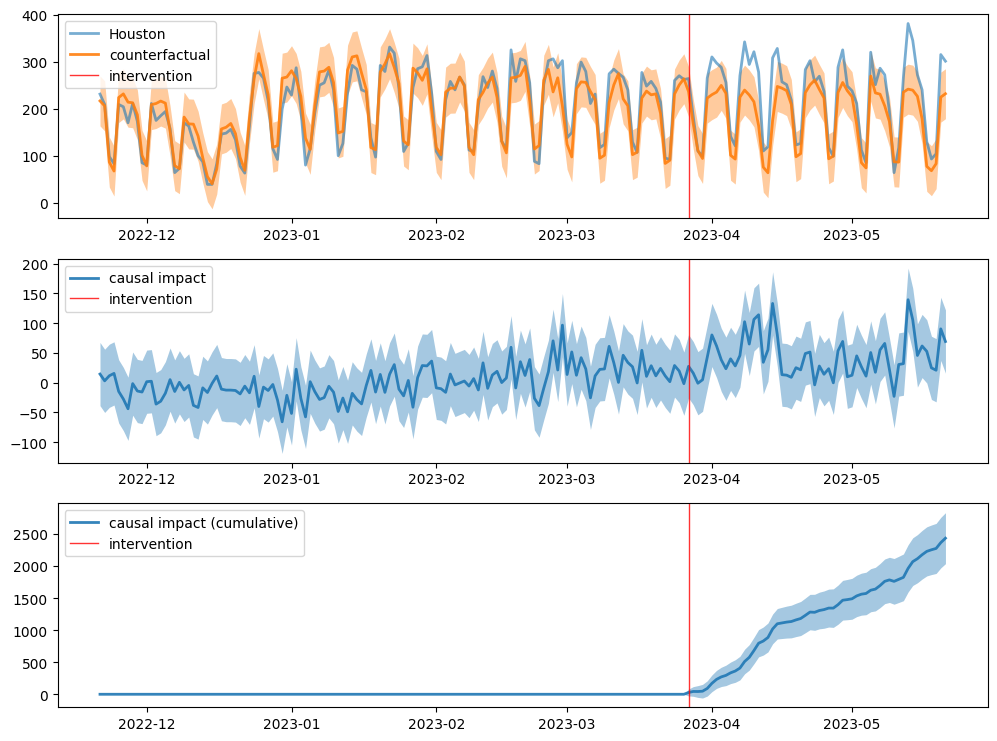

In [10]:
fig, Ax = causalinf.plot.main.plot_study(
     df, treated_unit, inference_model.counterfactual, inference_model.causal_impact, 
     inference_model.causal_impact_cum, step_intervention, figsize=(12.,9.),
     col_time="period_start_date"
)

## Plotly

Subplots feature in plotly is not amazing (e.g. hard to get separate legends, or assign individual titles to subplots). Therefore, when using a `plotly` backend, the `causalinf.plot.main.plot_study` will return a set of separate figures.

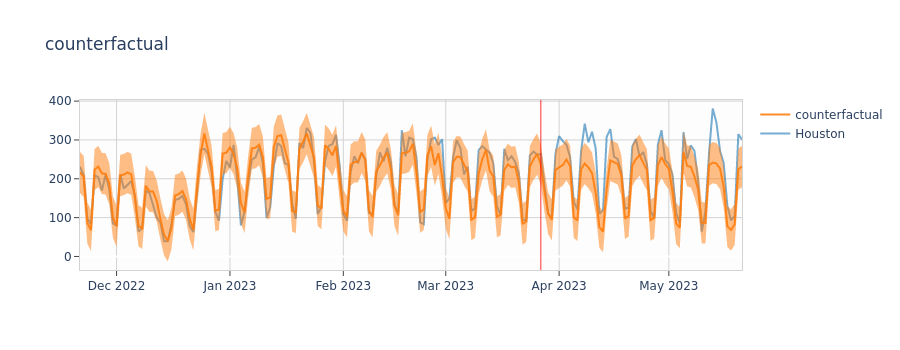

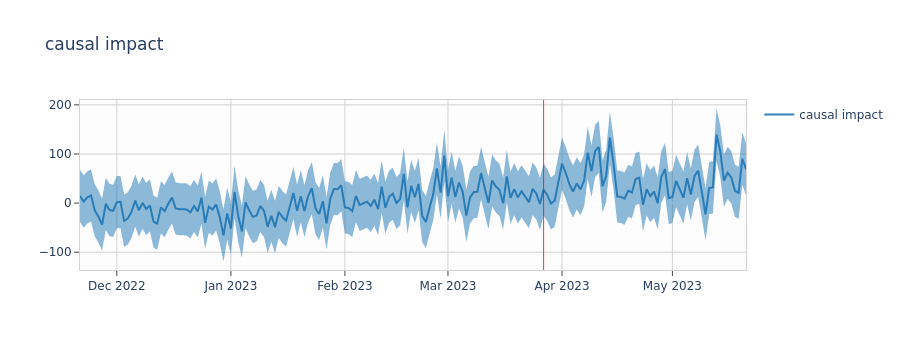

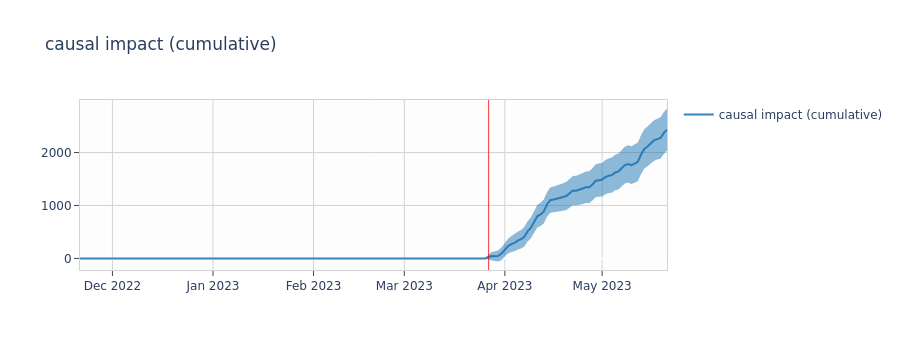

In [11]:
figs = causalinf.plot.main.plot_study(
     df, treated_unit, inference_model.counterfactual, inference_model.causal_impact, 
     inference_model.causal_impact_cum, step_intervention, backend="plotly", figsize=(900,350),
     col_time="period_start_date"
)
# for interactive figures - commented out as they won't render in github
# for _f in figs:
#     _f.show()
# for static render (as "png", "svg"; see plotly.io.renderers for all available options)
for _f in figs:
    _f.show("png")

# Distributions

### Matplotlib

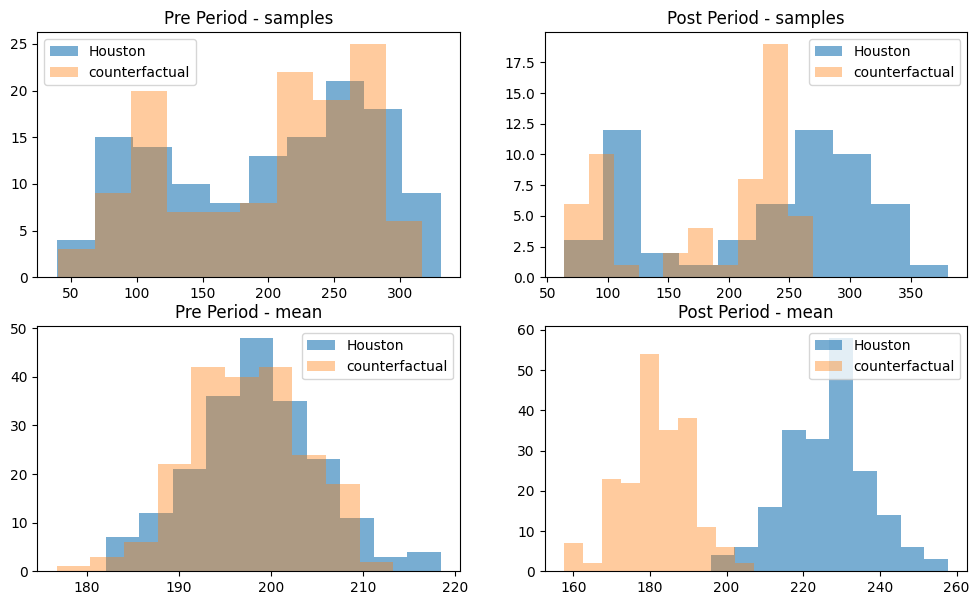

In [12]:
fig, Ax = causalinf.plot.main.plot_counterfactual_distributions(
    df, treated_unit, inference_model.counterfactual, step_intervention
)

# Format themes
The library comes with some formatting themes. For example:

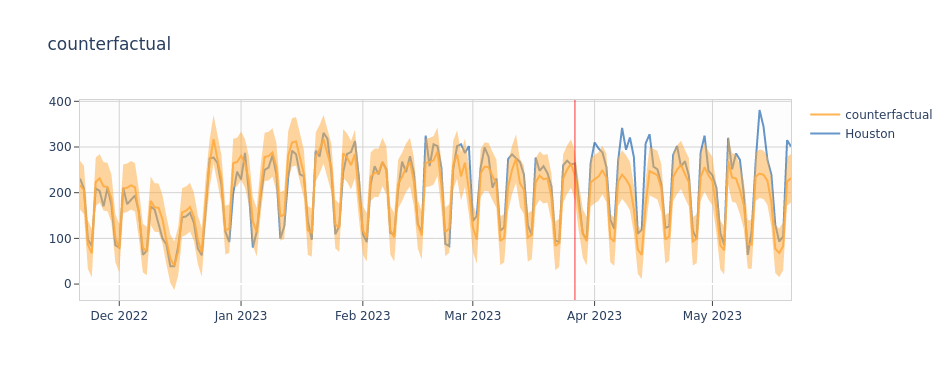

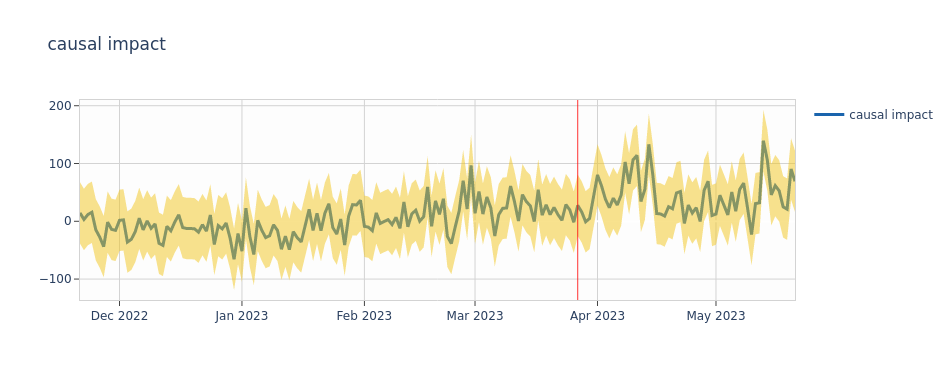

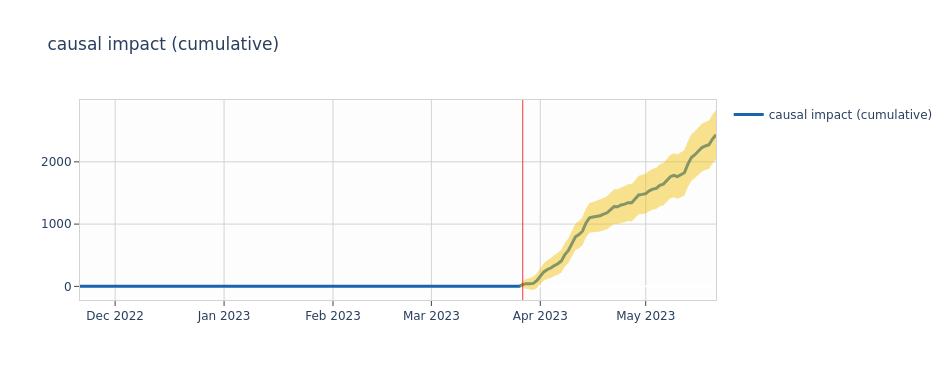

In [13]:
figs = causalinf.plot.main.plot_study(
     df, treated_unit, inference_model.counterfactual, inference_model.causal_impact, 
     inference_model.causal_impact_cum, step_intervention, backend="plotly", figsize=(950,380),
     col_time="period_start_date", fmt=causalinf.plot.core.formats["ctm"]
)
# for interactive figures - commented out as they won't render in github
# for _f in figs:
#     _f.show()
# for static render (as "png", "svg"; see plotly.io.renderers for all available options)
for _f in figs:
    _f.show("png")